In [46]:
%reload_ext autoreload
%autoreload 3
%matplotlib inline

import tkinter as tk
import re
import os
import numpy
import matplotlib.pyplot as plt
import mne
import stumpy
from tkinter import filedialog
from scipy.stats import pearsonr
from scipy.signal import correlate, correlation_lags, find_peaks, resample
from open_ephys.analysis import Session
from collections import defaultdict
from scipy.interpolate import interp1d

# Return two paths from the current working directory
current = os.getcwd()
parent_1 = os.path.dirname(current)
parent_2 = os.path.dirname(parent_1)
root_dir = os.path.join(parent_2, 'interface')
# Add the root directory to the system path
os.sys.path.append(root_dir)
# H:\github\nnc-ufmg\micromap\src\micromap\interface\micromap_utils.py
from micromap_utils import MicroMAPReader

In [47]:
def organize_files_by_info_and_name(folder_path):
    # Regex pattern to extract: name, date, time, 'ekg', and info
    pattern = re.compile(r'^(\d{3})_ekg_([a-zA-Z0-9]+)_(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})_([\d_]+)$')

    file_dict = defaultdict(lambda: defaultdict(list))

    for folder in os.listdir(folder_path):
        match = pattern.match(folder)
        if match:
            name = match.group(2)
            info = match.group(5)
            file_dict[info][name].append(os.path.join(folder_path, folder))
        else:
            print(f"Skipping unmatched filename: {folder}")

    return dict(file_dict)

In [48]:
root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

data_folder = filedialog.askdirectory(title = "Select the folder containing the data to be analyzed")
root.destroy()

file_structure = organize_files_by_info_and_name(data_folder)

from pprint import pprint
pprint(file_structure)

Skipping unmatched filename: results_filt_1_none_hz
{'1000_10_100': defaultdict(<class 'list'>,
                            {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\002_ekg_oe_2009-01-01_02-17-25_1000_10_100'],
                             'pc': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\002_ekg_pc_2025-04-26_17-09-01_1000_10_100']}),
 '1000_2_500': defaultdict(<class 'list'>,
                           {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\002_ekg_oe_2009-01-01_02-20-44_1000_2_500'],
                            'pc': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\002_ekg_pc_2025-04-26_17-12-29_1000_2_500']}),
 '2000_01_2000': defaultdict(<class 'list'>,
                             {'oe': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\010_ekg_oe_2009-01-01_02-40-16_2000_01_2000'],
                              'pc': ['C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\\010_ekg_pc_2025-04-26_17-32-00_2000_01_2000']}),
 '2000_5_200

In [49]:
class read_openephys():
    def __init__(self, path):
        path = [os.path.join(path, sub) for sub in os.listdir(path) if sub.startswith("Record Node") and os.path.isdir(os.path.join(path, sub))]
        if len(path) != 1:    
            raise ValueError("There are more than one Record Nodes")
        else:
            path = path[0]
        
        session = Session(path)
        recordings = session.recordings[0]
        continuous = recordings.continuous[0]

        sample_numbers = continuous.sample_numbers[0:-1]
        first_sample_index = sample_numbers[0]
        sample_numbers = sample_numbers - first_sample_index

        sampling_rate = continuous.metadata["sample_rate"]

        channels = continuous.metadata["channel_names"]
        channel_indexes = [i for i in range(len(channels)) if channels[i][0:2] == "CH"]
        data = continuous.get_samples(start_sample_index = 0, end_sample_index = -1, selected_channels = channel_indexes)

        data_shape = numpy.shape(data)

        if len(data_shape) > 1:
            if data_shape[0] > data_shape[1]:
                data = data.transpose()
                data_shape = numpy.shape(data)
        else:
            data_size = data_shape[0]
            data = numpy.reshape(data, (1, data_size))
        
        self.data = [a - numpy.mean(a) for a in data]
        self.data = numpy.array(self.data)
        print(data.shape)

        time_stamps = continuous.timestamps[0:-1]
        diff_time_stamps = numpy.diff(time_stamps)
        # check if the diff_time_stamps is constant
        if len(set(diff_time_stamps)) != 1:
            # If not, we need to interpolate the data to make it uniform
            # Create a new time array with uniform intervals
            uniform_time = numpy.arange(time_stamps[0], time_stamps[-1], 1/sampling_rate)
            # Interpolate the data to match the new time array
            interpolated_data = numpy.zeros((self.data.shape[0], len(uniform_time)))
            for i in range(self.data.shape[0]):
                interpolated_data[i, :] = numpy.interp(uniform_time, time_stamps, self.data[i, :])
            self.data = interpolated_data
        
        self.rate = sampling_rate
        self.samples = len(self.data[0])
        self.channels = len(self.data)
        self.max_value = numpy.max(self.data)
        self.min_value = numpy.min(self.data)

    def notch_filter(self, frequencies):
        frequencies = numpy.array(frequencies)
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.notch_filter(self.data[a], self.rate, frequencies)

    def bandpass_filter(self, low, high):
        for a in range(0, len(self.data)):
            self.data[a] = mne.filter.filter_data(self.data[a], self.rate, low, high, method='iir')


In [50]:
class analysis():
    def __init__(self, nnc, open_ephys, experiment_name):
        self.nnc = nnc
        self.open_ephys = open_ephys
        self.nnc_data = nnc.data
        self.openephys_data = open_ephys.data
        self.experiment_name = experiment_name
        self.num_channels = len(self.nnc_data)
        self.min_value = min(numpy.min(nnc.data).all(), open_ephys.min_value.all())
        self.max_value = max(numpy.max(nnc.data).all(), open_ephys.max_value.all())

    def plot_all(self, channels = []):                                                                                                                # Clears the last plot made in the interface
        if len(channels) > 0:
            channels_to_plot = channels
        else:
            channels_to_plot = range(0, self.num_channels)
        
        fig, ax = plt.subplots(1, 2, sharey = True)
        for a in channels_to_plot:                                                                                                          # Loop through all the rows of the matrix                             
            ax[0].plot(range(len(self.openephys_data[a])), self.openephys_data[a]*0.001 + a, color = (75/255, 75/255, 75/255, 1), linewidth = 0.5, label = 'OPEN EPHYS')
            ax[0].plot(range(len(self.nnc_data[a, :])), self.nnc_data[a, :]*0.001 + a, color = (160/255, 17/255, 8/255, 1), linewidth = 0.5, label = 'MICROMAP')

            channel_fft_nnc = numpy.fft.fft(self.nnc_data[a])
            channel_fft_openephys = numpy.fft.fft(self.openephys_data[a])
            freq = numpy.fft.fftfreq(len(channel_fft_nnc), 1/self.nnc.sampling_freq)
            
            freq = freq[0:int(len(freq)/2)]
            channel_fft_nnc = channel_fft_nnc[0:int(len(channel_fft_nnc)/2)]
            channel_fft_openephys = channel_fft_openephys[0:int(len(channel_fft_openephys)/2)]
            
            ax[1].plot(freq, numpy.abs(channel_fft_nnc)/numpy.max(numpy.abs(channel_fft_nnc)) + a, color = (160/255, 17/255, 8/255, 1), linewidth = 0.5, label = 'MICROMAP')
            ax[1].plot(freq, numpy.abs(channel_fft_openephys)/numpy.max(numpy.abs(channel_fft_openephys)) + a, color = (75/255, 75/255, 75/255, 1), linewidth = 0.5, label = 'OPEN EPHYS')

        for i in range(0, len(self.nnc_data[a, :]) + 1, self.nnc.sampling_freq*5):
            ax[0].axvline(x = i, color = 'black', linestyle = '--', label = "Error")

        ax[0].set_ylabel('CHANNELS', fontsize=16)
        ax[0].set_xlabel('TIME (s)', fontsize=16)
        ax[0].legend(['OPEN EPHYS', 'MICROMAP'], fontsize=14, loc='upper right')

        ax[1].set_xlabel('FREQUENCY (Hz)', fontsize=16)
        ax[1].set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax[1].legend(['OPEN EPHYS', 'MICROMAP'], fontsize=14, loc='upper right')
        
        plt.suptitle(self.experiment_name + " (in uV)")
        plt.tight_layout()
        plt.show()

    def correlaction(self, channel, samples, figures_folder = None):
        corr = correlate(self.nnc_data[channel][:samples], self.openephys_data[channel][:samples])
        lags = correlation_lags(len(self.nnc_data[channel][:samples]), len(self.openephys_data[channel][:samples]))
        
        corr = corr/(numpy.linalg.norm(self.nnc_data[channel][:samples]) * numpy.linalg.norm(self.openephys_data[channel][:samples]))
        
        if self.nnc.sampling_freq != self.open_ephys.rate:
            raise ValueError('Sample rate are different between both datasets')
        else:
            time_range = numpy.arange(samples)/self.nnc.sampling_freq

        print('Max correlation: ' + str(numpy.max(corr)) + ' at lag: ' + str(lags[numpy.argmax(corr)]/self.nnc.sampling_freq) + ' seconds')

        fig, (ax_nnc, ax_ope, ax_corr) = plt.subplots(3, 1, figsize=(10, 10))
        ax_nnc.plot(time_range, self.nnc_data[channel][:samples] - numpy.mean(self.nnc_data[channel][:samples]), color = (160/255, 17/255, 8/255, 1), linewidth = 2)
        ax_nnc.set_title(self.experiment_name + ' (channel ' + str(channel + 1) + ')\n\n' + 'MICROMAP', fontsize=16)
        ax_nnc.set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax_nnc.set_xlabel('TIME (s)', fontsize=16)
        ax_ope.plot(time_range, self.openephys_data[channel][:samples] - numpy.mean(self.openephys_data[channel][:samples]), color = (75/255, 75/255, 75/255, 1), linewidth = 2)
        ax_ope.set_title('OPEN EPHYS', fontsize=18)
        ax_ope.set_xlabel('TIME (s)', fontsize=16)
        #ax_ope.set_xlabel('Time (seconds)', fontsize=14)
        ax_ope.set_ylabel('AMPLITUDE (uV)', fontsize=16)
        ax_corr.plot(lags/self.nnc.sampling_freq, corr)
        ax_corr.set_title('CROSS-CORRELATED SIGNAL', fontsize=18)
        ax_corr.set_xlabel('LAG (s)', fontsize=14)
        ax_nnc.margins(0, 0.1)
        ax_ope.margins(0, 0.1)
        ax_corr.margins(0, 0.1)

        # set tick labels font
        for label in (ax_nnc.get_xticklabels() + ax_nnc.get_yticklabels() + ax_ope.get_xticklabels() + ax_ope.get_yticklabels() + ax_corr.get_xticklabels() + ax_corr.get_yticklabels()):
            label.set_fontsize(16)
        
        plt.tight_layout()
        if figures_folder != None:
            plt.savefig(figures_folder + '/corr_' + self.experiment_name.lower().replace(' ', '_') + '.png')
            plt.savefig(figures_folder + '/corr_' + self.experiment_name.lower().replace(' ', '_') + '.svg')
        else:
            plt.show()

    def lag_correction(self, use_channels = []):
        self.nnc_data = correct_clock_drift(self.nnc_data, 3.48e-5)
        openephys_len = len(self.openephys_data[0])
        nnc_len = len(self.nnc_data[0])
        window_init = int(0.05*openephys_len)
        window_end = int(0.1*openephys_len)

        if len(use_channels) > 0:
            search_by = self.openephys_data[[use_channels[0], use_channels[1]], window_init:window_end]
            search_in = self.nnc_data[[use_channels[0], use_channels[1]], 0:int(0.2*openephys_len)]
        else:
            search_by = self.openephys_data[:, window_init:window_end]
            search_in = self.nnc_data[:, 0:int(0.2*openephys_len)]

        search_by = search_by.astype(numpy.float64)
        search_in = search_in.astype(numpy.float64)

        match = stumpy.match(search_by, search_in, max_matches = 1, normalize = True)
        match_indices = match[:, 1]

        if len(match_indices) == 0:
            raise ValueError('No match found')
        elif len(match_indices) > 1:
            raise ValueError('More than one match found')
        else:
            lag = int(match_indices[0]) - window_init

        print(f'The lag is {lag} samples')

        if lag > 0:
            self.nnc_data = self.nnc_data[:, lag:]
        else:
            self.openephys_data = self.openephys_data[:, abs(lag):]
        
        openephys_len = len(self.openephys_data[0])
        nnc_len = len(self.nnc_data[0])

        if nnc_len > openephys_len:
            self.nnc_data = self.nnc_data[:, :openephys_len]
        else:
            self.openephys_data = self.openephys_data[:, :nnc_len]

    def psd(self):
        plt.psd(self.nnc_data[0], NFFT=None, Fs=2000, Fc=None, detrend=None, window=None, noverlap=100, pad_to=None, sides=None, scale_by_freq=None, return_line=None)
        plt.title(self.experiment_name)
        plt.show()

    def average_window(self, sampling_frequency, plot = True, figures_folder = None):
        window = int(sampling_frequency/10)
        heart_beat_nnc = []
        for a in range(0, self.num_channels):
            peaks_nnc = find_peaks(self.nnc_data[a], height=180, distance=300)
            for peak in peaks_nnc[0][1:-1]:
                heart_beat_nnc.append(list(self.nnc_data[a][peak-window:peak+window]))

        heart_beat_nnc = numpy.array(heart_beat_nnc)
        self.average_nnc = numpy.mean(heart_beat_nnc, axis=0)

        heart_beat_openephys = []
        for a in range(0, self.num_channels):
            peaks_openephys = find_peaks(self.openephys_data[a], height=180, distance=300)
            for peak in peaks_openephys[0][1:-1]:
                heart_beat_openephys.append(list(self.openephys_data[a][peak-window:peak+window]))

        heart_beat_openephys = numpy.array(heart_beat_openephys)
        self.average_openephys = numpy.mean(heart_beat_openephys, axis=0)

        if plot:
            fig, (ax) = plt.subplots(1, 1, figsize=(4.8, 4.8))
            ax.plot(self.average_nnc, color = (160/255, 17/255, 8/255, 1), linewidth = 2)
            ax.plot(self.average_openephys, color = (75/255, 75/255, 75/255, 1), linewidth = 2)
            ax.set_xlabel('TIME (s)', fontsize=16)
            # ax.set_xlabel('Tempo (segundos)', fontsize=14)
            ax.set_ylabel('AMPLITUDE (uV)', fontsize=16)
            ax.margins(0, 0.1)
            ax.margins(0, 0.1)
            ax.legend(['MICROMAP','OPEN EPHYS'], fontsize=14)
            #plt.title(self.experiment_name)
            print(self.experiment_name + '.png')

            # set tick labels font
            for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontsize(16)

            plt.tight_layout()
            if figures_folder != None:
                plt.savefig(figures_folder + '/avg_' + self.experiment_name.lower().replace(' ', '_') + '.png')
                plt.savefig(figures_folder + '/avg_' + self.experiment_name.lower().replace(' ', '_') + '.svg')
            else:
                plt.show()

    def person_correlation(self):
        # correlaction = numpy.corrcoef(self.average_nnc, self.average_openephys)
        # return correlaction[0][1]

        # correlation = pearsonr(self.average_nnc, self.average_openephys)
        correlation = []
        p_value = []

        for channel in range(self.num_channels):
            corr = pearsonr(self.nnc_data[channel,:], self.openephys_data[channel,:])
            p_value.append(corr[1])
            correlation.append(corr[0])
        
        return correlation, p_value
    
    def euclidean_distance(self):
        distance = numpy.linalg.norm(self.average_nnc - self.average_openephys)
        return distance
        
def correct_clock_drift(signal, clock_error_per_sample):
    """
    Corrige a distorção temporal causada por drift no clock.

    Args:
        signal: vetor do sinal original
        clock_error_per_sample: erro por amostra (ex: 3.48e-5)

    Returns:
        signal_corrected: vetor de sinal corrigido no tempo
    """
    n_samples = signal.shape[1]
    t_original = numpy.linspace(0, 1, n_samples)
    # O Arduino "acelerou", então o tempo real é mais longo
    t_corrected = t_original * (1 + clock_error_per_sample)

    signal_rescaled = numpy.zeros_like(signal)

    for ch in range(signal.shape[0]):
        # Agora queremos reinterpolar para voltar para tempo perfeito (0 a 1)
        interpolator = interp1d(t_corrected, signal[ch, :], kind = 'linear', fill_value = "extrapolate")
        signal_rescaled[ch, :] = interpolator(t_original)

    return signal_rescaled

Open Ephys file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\002_ekg_oe_2009-01-01_02-11-26_2000_5_200
PC file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\002_ekg_pc_2025-04-26_17-02-45_2000_5_200
(32, 240895)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 s)

Setting up band-stop filter



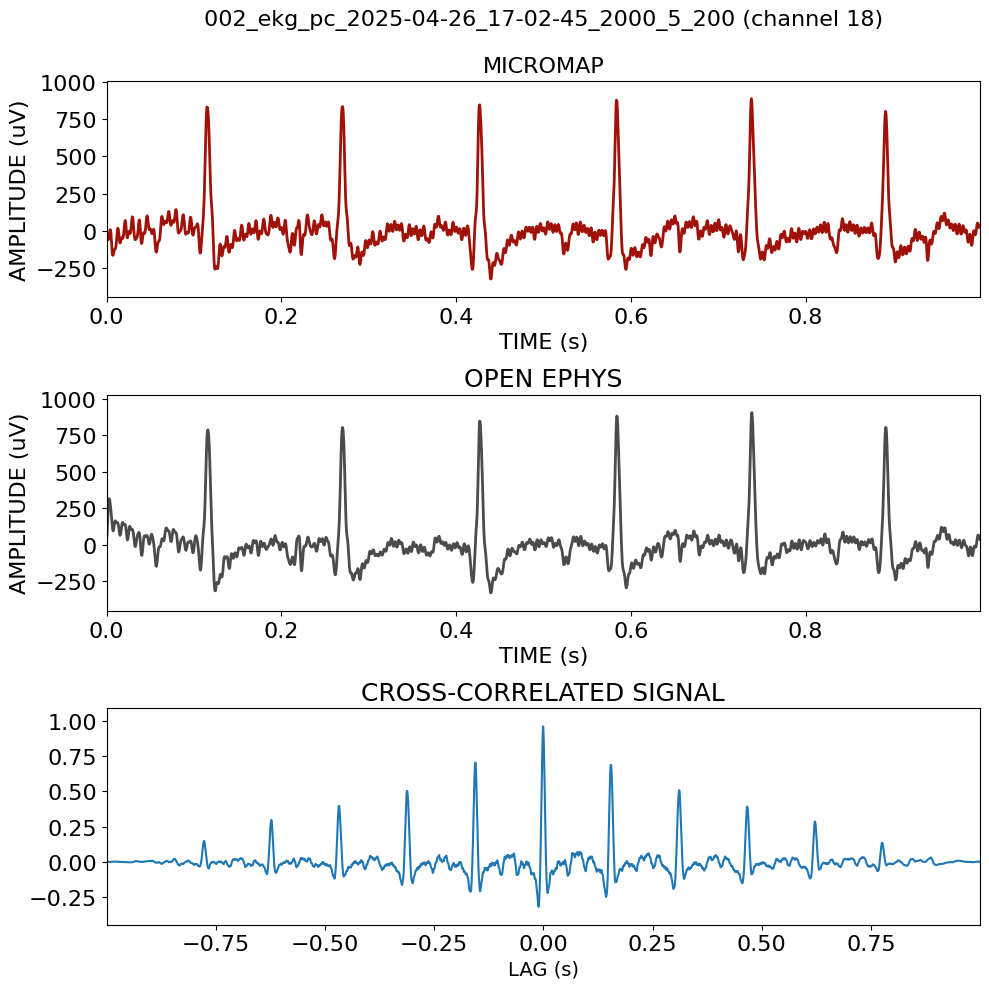

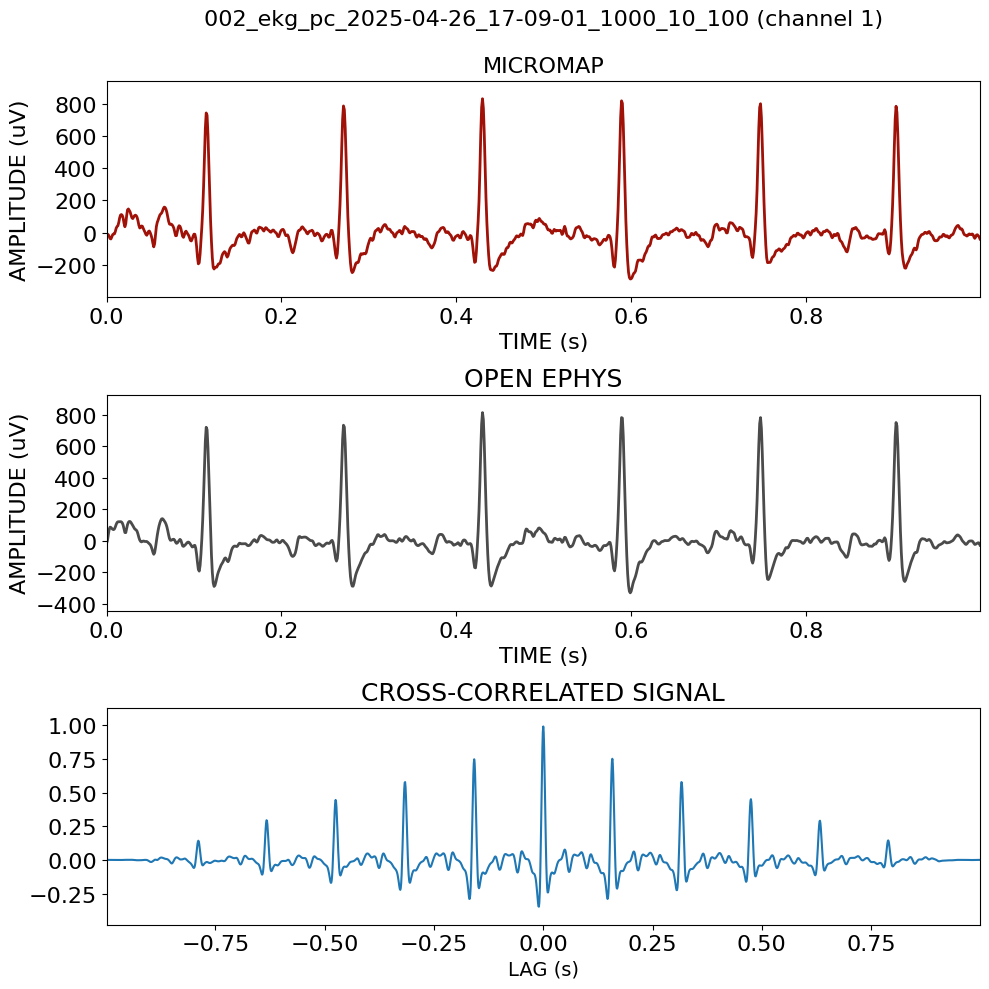

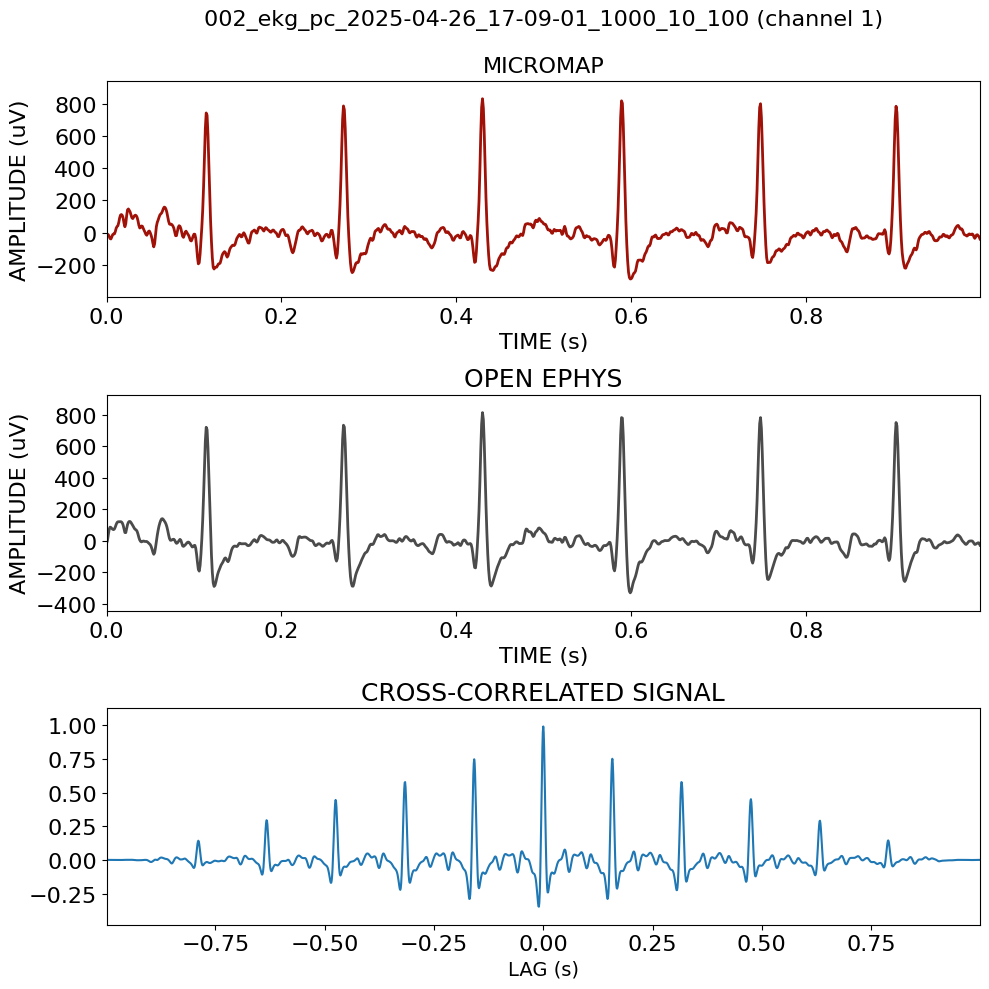

Experiment 1000_10_100: [np.float64(0.9930352389453264), np.float64(0.9934885630411753), np.float64(0.9937554474251844), np.float64(0.9945146633865614), np.float64(0.991342247180471), np.float64(0.9960840718487112), np.float64(0.9940388400887826), np.float64(0.9900870708913926), np.float64(0.9942880960980421), np.float64(0.9826637098802675), np.float64(0.9829796545105172), np.float64(0.975900105175812), np.float64(0.9815454641380367), np.float64(0.9586996687599453), np.float64(0.9741902998440355), np.float64(0.968906597994567)]
Open Ephys file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\002_ekg_oe_2009-01-01_02-20-44_1000_2_500
PC file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\002_ekg_pc_2025-04-26_17-12-29_1000_2_500
(32, 120575)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

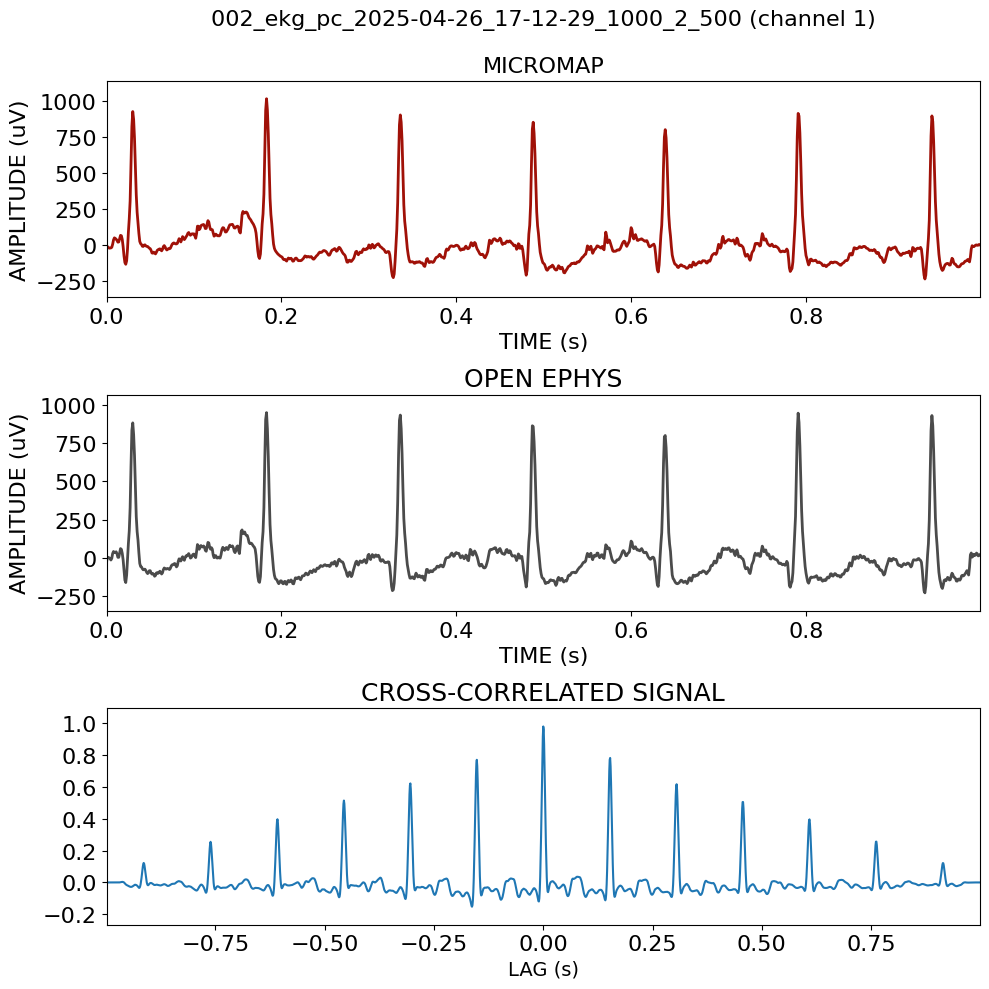

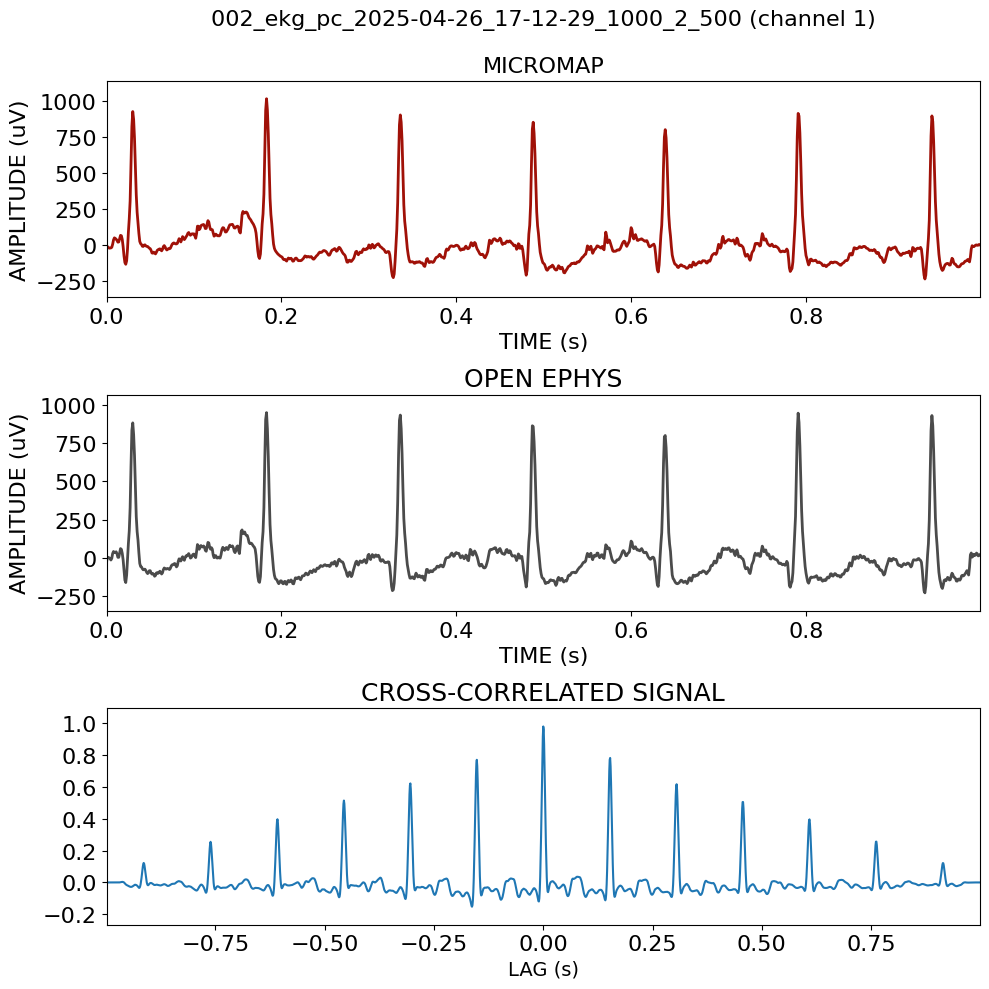

Experiment 1000_2_500: [np.float64(0.986751994115419), np.float64(0.9866065857833821), np.float64(0.9872122124601684), np.float64(0.9864508512063878), np.float64(0.9857651227163694), np.float64(0.9871170491680473), np.float64(0.9853199665462244), np.float64(0.9827425344020713), np.float64(0.9850701456602017), np.float64(0.9811491658404917), np.float64(0.9817209232219819), np.float64(0.9762939805584391), np.float64(0.9777552255985055), np.float64(0.9743891372991014), np.float64(0.9732050533164683), np.float64(0.9743835066623265)]
Open Ephys file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\010_ekg_oe_2009-01-01_02-40-16_2000_01_2000
PC file: C:/Users/mcjpe/Desktop/micromap_test/ekg_test_pc\010_ekg_pc_2025-04-26_17-32-00_2000_01_2000
(32, 1201151)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

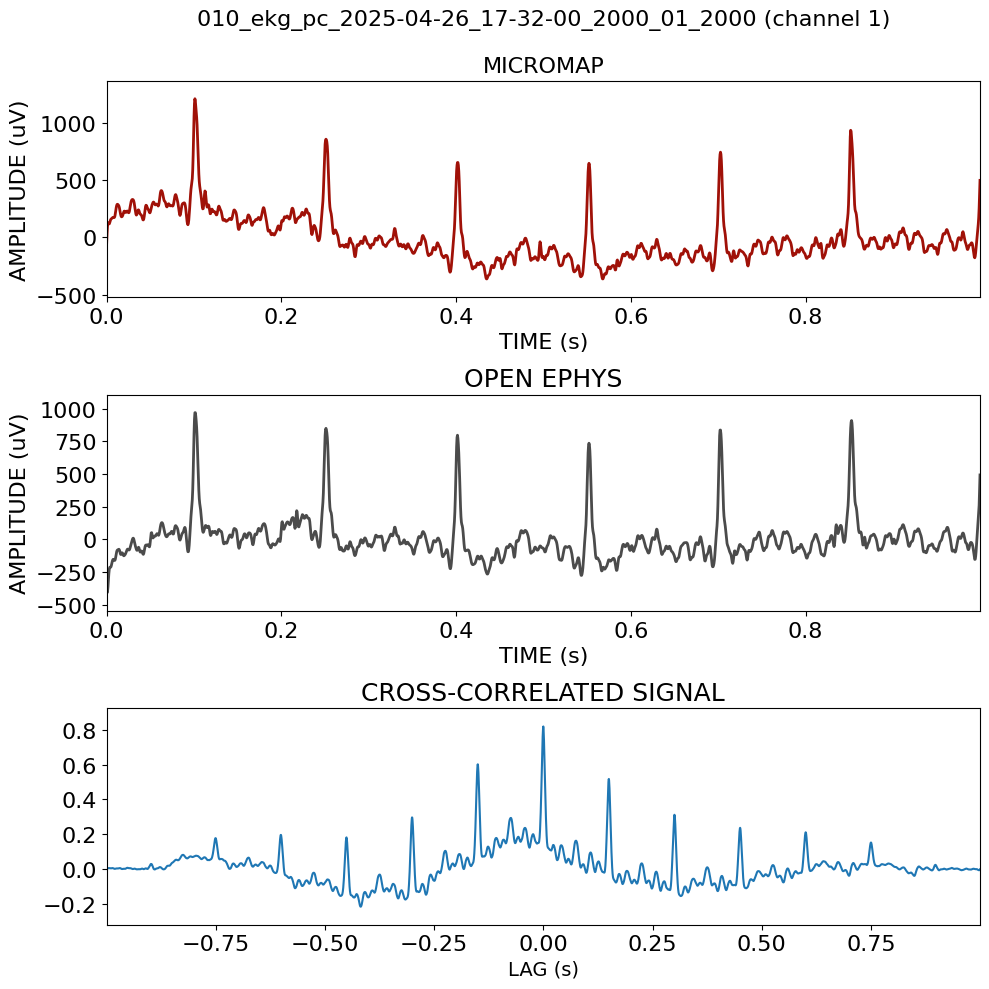

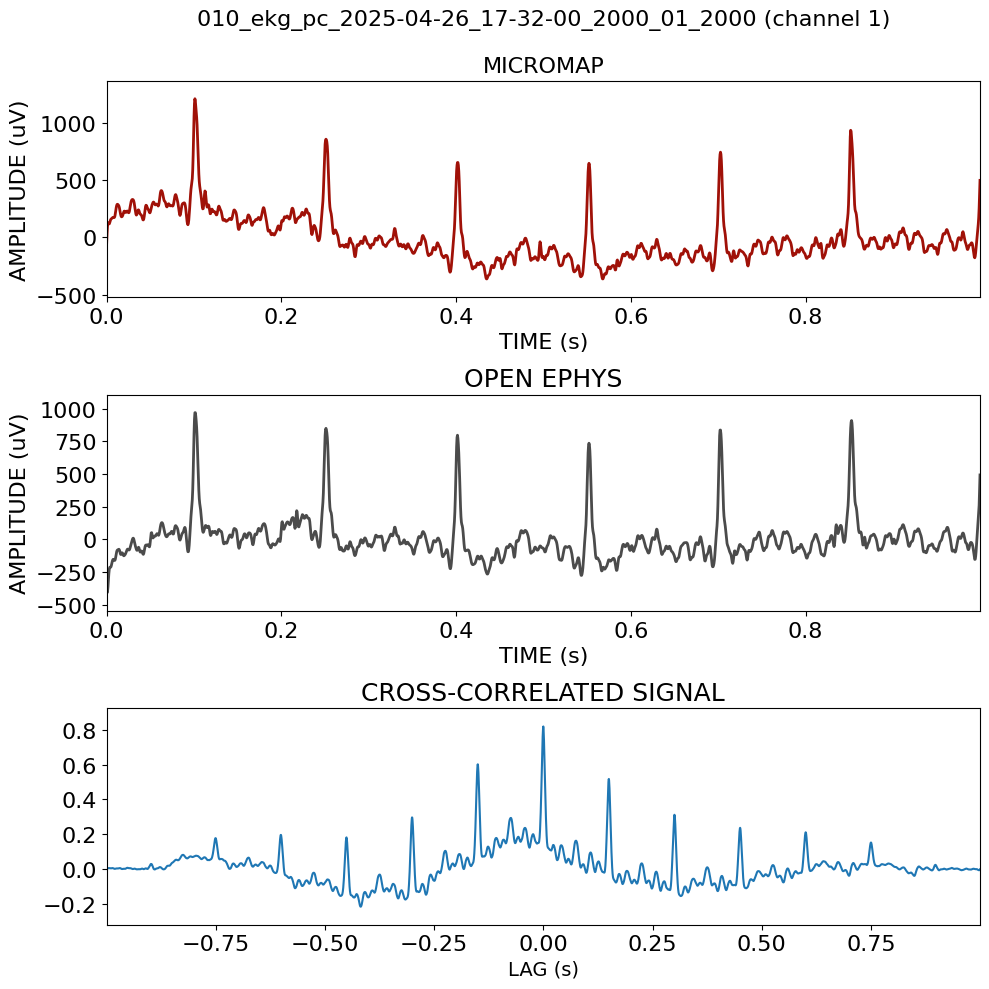

Experiment 2000_01_2000: [np.float64(0.9745977697962714), np.float64(0.9750376376799438), np.float64(0.9752928039867609), np.float64(0.9756527759347206), np.float64(0.9760824089635295), np.float64(0.9768171511622122), np.float64(0.9766153453980765), np.float64(0.9767700395621745), np.float64(0.9778647943809456), np.float64(0.9778697026125438), np.float64(0.9785808633415954), np.float64(0.9785654483044739), np.float64(0.9790500059453644), np.float64(0.9792641069169529), np.float64(0.9795913073190414), np.float64(0.9805219792194828)]


In [51]:
%matplotlib inline

signal_correlation = []
signal_correlation_p_value = []

root = tk.Tk()
root.attributes('-topmost',True)
root.iconify()

figures_folder = filedialog.askdirectory(title = "Select the folder to save figures")
root.destroy()

validation = {}

for count_n, n in enumerate(file_structure):
    validation[n] = {}
    oe_folder = file_structure[n]['oe'][0]
    try:
        pc_folder = file_structure[n]['rpi'][0]
    except:
        pc_folder = file_structure[n]['pc'][0]

    print('Open Ephys file: ' + oe_folder)
    print('PC file: ' + pc_folder)

    validation[n]['open_ephys'] = read_openephys(oe_folder)
    validation[n]['open_ephys'].notch_filter([60, 120])
    validation[n]['open_ephys'].bandpass_filter(1, 300)
    validation[n]['num_channels'] = validation[n]['open_ephys'].channels
    validation[n]['sample_frequency'] = validation[n]['open_ephys'].rate

    validation[n]['nnc'] = MicroMAPReader(pc_folder, counter_type = 'n')
    validation[n]['nnc'].notch_filter([60, 120])
    validation[n]['nnc'].bandpass_filter(1, 300)

    print(f'Data size: (OE) {validation[n]["open_ephys"].samples} - (NNC) {validation[n]["nnc"].data.shape[1]}')

    if validation[n]['nnc'].num_channels != validation[n]['num_channels']:
        raise ValueError('Number of channels are different between both datasets - NNC: ' + str(validation[n]['nnc'].num_channels) + ' - Open Ephys: ' + str(validation[n]['num_channels']))
    if validation[n]['nnc'].sampling_freq != validation[n]['sample_frequency']:
        print('Sample rate are different between both datasets - NNC: ' + str(validation[n]['nnc'].sampling_freq) + ' - Open Ephys: ' + str(validation[n]['sample_frequency']))
        if validation[n]['nnc'].sampling_freq > validation[n]['sample_frequency']:
            validation[n]['nnc'].data = resample(validation[n]['nnc'].data, int(validation[n]['nnc'].sampling_freq/validation[n]['sample_frequency']*validation[n]['nnc'].data.shape[1]), axis=1)
            validation[n]['nnc'].sampling_freq = validation[n]['sample_frequency']
        else:
            validation[n]['nnc'].data = resample(validation[n]['nnc'].data, int(validation[n]['sample_frequency']/validation[n]['nnc'].sampling_freq*validation[n]['nnc'].data.shape[1]), axis=1)
            validation[n]['nnc'].sampling_freq = validation[n]['sample_frequency']
    packet_loss = validation[n]['nnc'].check_packet_counter(plot = False)
    # if packet_loss == False:
    #     raise ValueError('Packet loss detected in the NNC data')

    experiment_name = os.path.basename(pc_folder)

    validation[n]['experiment_name'] = experiment_name
    validation[n]['comparision'] = analysis(validation[n]['nnc'], validation[n]['open_ephys'], validation[n]['experiment_name'])

    if n != '2000_5_200' and n != '2000_2_1000':
        random_channels = numpy.random.randint(0, 16, 2)
        validation[n]['comparision'].lag_correction(use_channels = random_channels)
        # validation[n]['comparision'].plot_all(channels = random_channels)
    else:
        random_channels = numpy.random.randint(17, 32, 2)
        validation[n]['comparision'].lag_correction(use_channels = random_channels)
        # validation[n]['comparision'].plot_all(channels = random_channels)

    if n != '2000_5_200' and n != '2000_2_1000':
        validation[n]['comparision'].correlaction(0, int(validation[n]['nnc'].sampling_freq), figures_folder = figures_folder)
        validation[n]['comparision'].correlaction(0, int(validation[n]['nnc'].sampling_freq), figures_folder = None)
    
        validation[n]['pearson'] = validation[n]['comparision'].person_correlation()
        signal_correlation.append(validation[n]['pearson'][0][0:16])
        signal_correlation_p_value.append(validation[n]['pearson'][1][0:16])
    else:
        validation[n]['comparision'].correlaction(17, int(validation[n]['nnc'].sampling_freq), figures_folder = figures_folder)
        # validation[n]['comparision'].correlaction(17, int(validation[n]['nnc'].sampling_freq), figures_folder = None)
        validation[n]['pearson'] = validation[n]['comparision'].person_correlation()
        signal_correlation.append(validation[n]['pearson'][0][16:32])
        signal_correlation_p_value.append(validation[n]['pearson'][1][16:32])

    print('Experiment ' + str(n) + ': ' + str(signal_correlation[-1]))

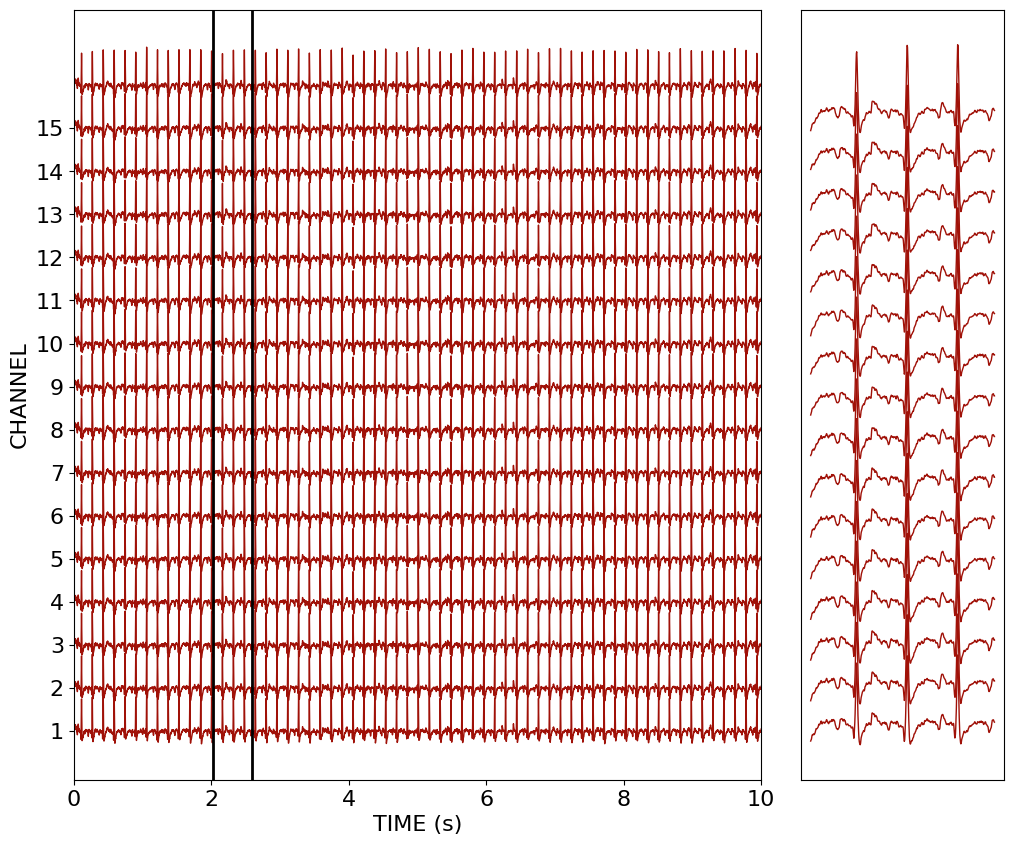

In [54]:
if 'pc' in file_structure[list(file_structure.keys())[0]]:
    comp = list(validation.keys())[1]
else:
    comp = list(validation.keys())[1]

obj = validation[comp]['nnc']
data = obj.data
rate = obj.sampling_freq
  
num_channels = data.shape[0]                                                                                       
time = numpy.arange(data.shape[1])                                                                                 # Creates a vector with the number of samples lenght
time = time /rate                                                                                                   # Converts the samples to seconds

fig = plt.figure(figsize=(12, 10))                                                                                 # Creates a figure with the size of 10x5 inches
ax_0 = fig.add_subplot(1, 4, (1,3))                                                                                  # Creates a 1x3 matrix of subplots
ax_1 = fig.add_subplot(1, 4, 4)                                                                                  # Creates a 1x1 matrix of subplots

lim_0 = 2020
lim_1 = 2600

plot_channels = range(16)

for ch in plot_channels:                                                                                             # Loop through all the rows of the matrix
    ax_0.plot(time, data[ch]*0.001 + ch + 1, color = (160/255, 17/255, 8/255, 1), linewidth = 1)
    ax_1.plot(time[lim_0:lim_1], data[ch, lim_0:lim_1]*0.002 + ch + 1, color = (160/255, 17/255, 8/255, 1), linewidth = 1)


ax_0.axvline(x = lim_0/rate, color = 'black', linestyle = '-', linewidth = 2)
ax_0.axvline(x = lim_1/rate, color = 'black', linestyle = '-', linewidth = 2)
ax_0.set_xlabel('TIME (s)', fontsize = 16)
ax_0.set_ylabel('CHANNEL', fontsize = 16)
ax_0.set_yticks(range(1, max(plot_channels) + 1))
ax_0.set_yticklabels(range(1, max(plot_channels) + 1))
ax_0.set_xlim(0, time[10000])

ax_1.set_xticklabels([])
ax_1.set_yticklabels([])
ax_1.set_xticks([])
ax_1.set_yticks([])

# set tick labels font
for label in (ax_0.get_xticklabels() + ax_0.get_yticklabels()):
    label.set_fontsize(16)

plt.savefig(figures_folder + '/raw_' + experiment_name.lower().replace(' ', '_') + '_all.png')
plt.savefig(figures_folder + '/raw_' + experiment_name.lower().replace(' ', '_') + '_all.svg')

plt.show()

In [ ]:
print(signal_correlation)

for experiment in range(len(signal_correlation)):
    print('Experiment ' + str(experiment) + ': ' + str(signal_correlation[experiment]))

print('Mean correlaction: ' + str(numpy.mean(signal_correlation)))
print('Standard deviation: ' + str(numpy.std(signal_correlation)))

report_file = open(os.path.join(figures_folder, 'correlaction_report.txt'), 'w')
report_file.write('Experiment\t' + '\t'.join([str(i) for i in range(1, 17)]) + '\n')
for experiment in range(len(signal_correlation)):
    report_file.write(str(experiment) + '\t' + '\t'.join([str(i) for i in signal_correlation[experiment]]) + '\n')
report_file.write('Mean\t' + '\t'.join([str(i) for i in numpy.mean(signal_correlation, axis = 0)]) + '\n')
report_file.write('Standard deviation\t' + '\t'.join([str(i) for i in numpy.std(signal_correlation, axis = 0)]) + '\n')

report_file.write('\n\nTotal mean: ' + str(numpy.mean(signal_correlation)) + '\n')
report_file.write('Total standard deviation: ' + str(numpy.std(signal_correlation)) + '\n')

[[np.float64(0.9569676429160922), np.float64(0.9576182273309741), np.float64(0.9516458040006688), np.float64(0.9488376619671205), np.float64(0.9614440849600449), np.float64(0.968819006715534), np.float64(0.9609145990465453), np.float64(0.9662900264290191), np.float64(0.9603385844381205), np.float64(0.9628879369904109), np.float64(0.9647657442243044), np.float64(0.9668854257144387), np.float64(0.8100319952354312), np.float64(0.9670335695449636), np.float64(0.9881079715283416), np.float64(0.9793508353732373)], [np.float64(0.9930352389453264), np.float64(0.9934885630411753), np.float64(0.9937554474251844), np.float64(0.9945146633865614), np.float64(0.991342247180471), np.float64(0.9960840718487112), np.float64(0.9940388400887826), np.float64(0.9900870708913926), np.float64(0.9942880960980421), np.float64(0.9826637098802675), np.float64(0.9829796545105172), np.float64(0.975900105175812), np.float64(0.9815454641380367), np.float64(0.9586996687599453), np.float64(0.9741902998440355), np.floa

47